# Multi-Scale Push-Pull Layer for Robust Convolutional Neural Networks
## With FGSM and PGD Attack

### Vinayak Santosh Ranshevare

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class MultiScalePushPullLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes, alphas):
        super(MultiScalePushPullLayer, self).__init__()
        self.scales = len(kernel_sizes)
        self.push_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, k, padding=k//2)
            for k in kernel_sizes
        ])
        self.pull_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, k, padding=k//2)
            for k in kernel_sizes
        ])
        self.alphas = nn.Parameter(torch.tensor(alphas))

    def forward(self, x):
        push_responses = []
        pull_responses = []

        for i in range(self.scales):
            push = F.relu(self.push_convs[i](x))
            pull = self.pull_convs[i](x)
            pull = F.interpolate(pull, size=push.shape[2:], mode='bilinear', align_corners=False)
            pull = F.relu(-pull)

            push_responses.append(push)
            pull_responses.append(pull)

        combined_response = sum([push - self.alphas[i] * pull
                                 for i, (push, pull) in enumerate(zip(push_responses, pull_responses))])

        return combined_response

class MultiScalePushPullCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MultiScalePushPullCNN, self).__init__()
        self.push_pull = MultiScalePushPullLayer(3, 64, kernel_sizes=[3, 5, 7], alphas=[0.5, 0.3, 0.2])
        self.conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.push_pull(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# FGSM Attack
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# PGD Attack
def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    perturbed_images = images.clone().detach()
    for _ in range(num_iter):
        perturbed_images.requires_grad = True
        outputs = model(perturbed_images)
        model.zero_grad()
        loss = F.nll_loss(outputs, labels)
        loss.backward()

        with torch.no_grad():
            adv_images = perturbed_images + alpha * perturbed_images.grad.sign()
            delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
            perturbed_images = torch.clamp(images + delta, min=0, max=1).detach()

    return perturbed_images

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiScalePushPullCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

# Evaluation function
def evaluate(model, dataloader, attack_type=None, epsilon=0.03, alpha=0.01, num_iter=10):
    model.eval()
    correct = 0
    total = 0
    for data in dataloader:
        images, labels = data[0].to(device), data[1].to(device)

        if attack_type == 'FGSM':
            images.requires_grad = True
            outputs = model(images)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()
            images = fgsm_attack(images, epsilon, images.grad.data)
        elif attack_type == 'PGD':
            images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Evaluate on clean test data
clean_accuracy = evaluate(model, testloader)
print(f'Accuracy on clean test images: {clean_accuracy:.2f}%')

# Evaluate on FGSM adversarial examples
fgsm_accuracy = evaluate(model, testloader, attack_type='FGSM', epsilon=0.03)
print(f'Accuracy on FGSM adversarial examples: {fgsm_accuracy:.2f}%')

# Evaluate on PGD adversarial examples
pgd_accuracy = evaluate(model, testloader, attack_type='PGD', epsilon=0.03, alpha=0.01, num_iter=10)
print(f'Accuracy on PGD adversarial examples: {pgd_accuracy:.2f}%')

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[1,   200] loss: 1.663
[1,   400] loss: 1.233
[1,   600] loss: 1.030
[2,   200] loss: 0.817
[2,   400] loss: 0.741
[2,   600] loss: 0.732
[3,   200] loss: 0.524
[3,   400] loss: 0.511
[3,   600] loss: 0.525
[4,   200] loss: 0.277
[4,   400] loss: 0.341
[4,   600] loss: 0.340
[5,   200] loss: 0.162
[5,   400] loss: 0.177
[5,   600] loss: 0.222
[6,   200] loss: 0.083
[6,   400] loss: 0.118
[6,   600] loss: 0.160
[7,   200] loss: 0.098
[7,   400] loss: 0.108
[7,   600] loss: 0.135
[8,   200] loss: 0.072
[8,   400] loss: 0.087
[8,   600] loss: 0.109
[9,   200] loss: 0.064
[9,   400] loss: 0.079
[9,   600] loss: 0.100
[10,   200] loss: 0.057
[10,   400] loss: 0.091
[10,   600] loss: 0.095
Finished Training
Accuracy on clean test images: 73.93%
Accuracy on FGSM adversarial examples: 24.01%
Accuracy on PGD adversarial examples: 4.43%


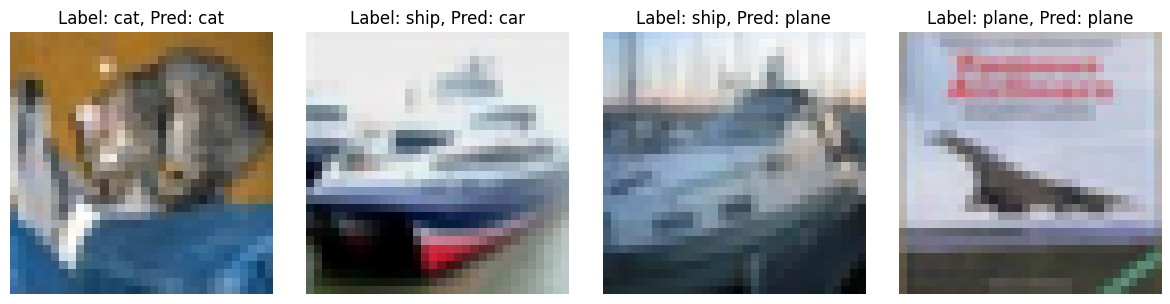

Finished visualization


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show images with predictions
def imshow(img, label, pred):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'Label: {classes[label]}, Pred: {classes[pred]}')
    plt.axis('off')

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images to the same device as the model
images = images.to(device)

# Get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show images and predictions
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(12, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    imshow(images[i].cpu(), labels[i], predicted[i].cpu())
plt.tight_layout()
plt.show()

print('Finished visualization')

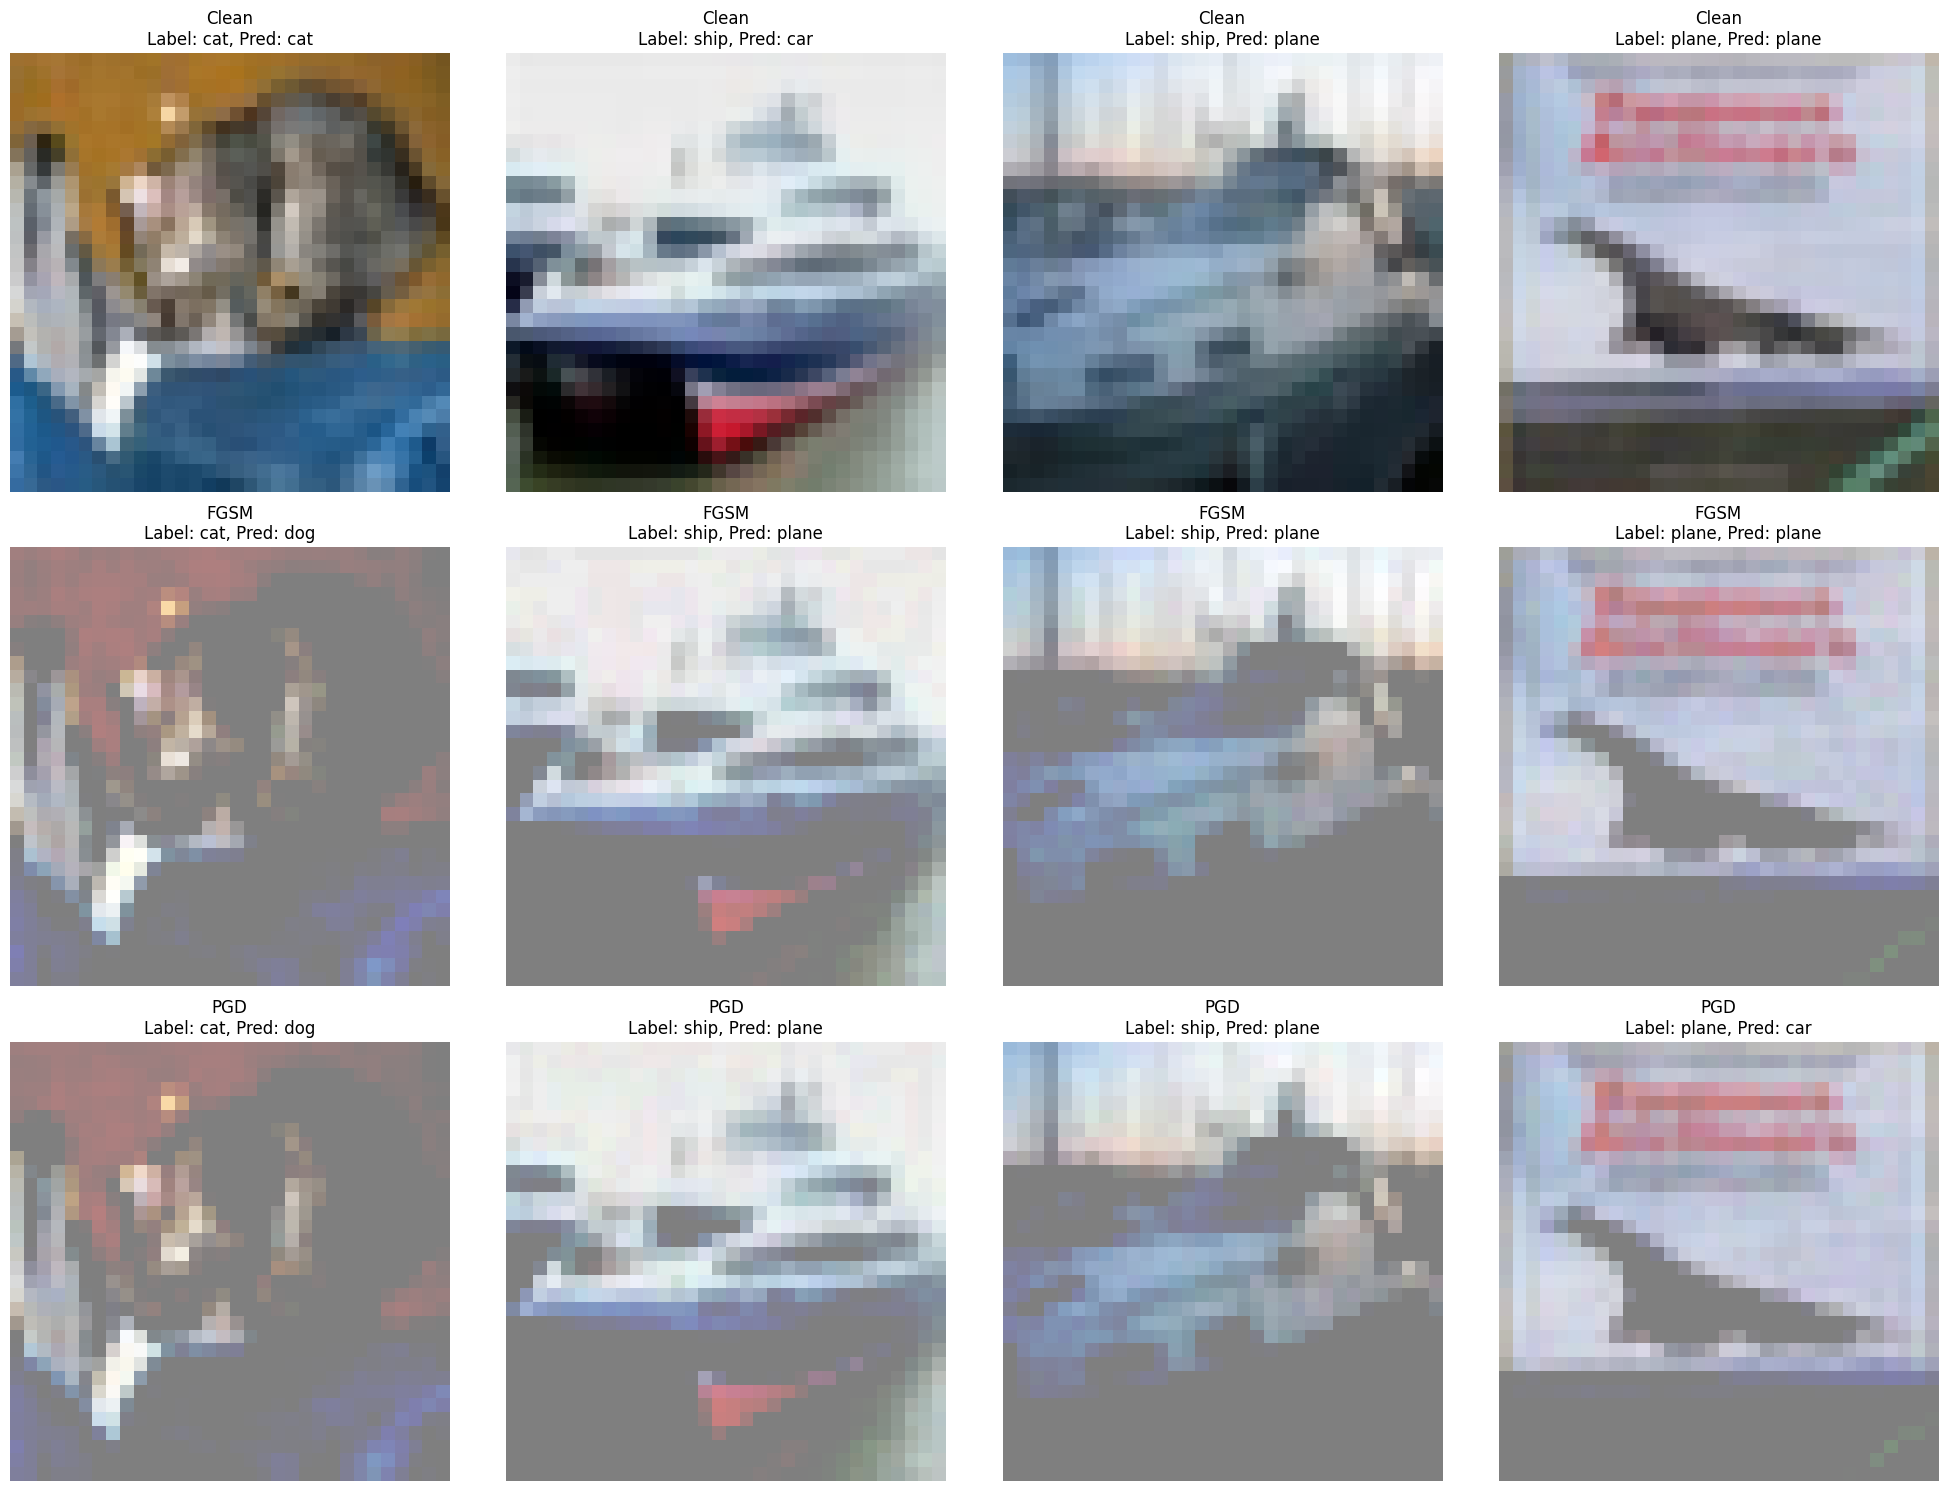

Finished visualization
Accuracy on clean images: 65.62%
Accuracy on FGSM adversarial images: 25.00%
Accuracy on PGD adversarial images: 3.12%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, label, pred):
    img = img.cpu().detach()  # Move to CPU and detach from computation graph
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'Label: {classes[label]}, Pred: {classes[pred]}')
    plt.axis('off')

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images to the same device as the model
images = images.to(device)
labels = labels.to(device)

# Generate FGSM and PGD adversarial examples
fgsm_images = images.clone()
fgsm_images.requires_grad = True
fgsm_outputs = model(fgsm_images)
loss = criterion(fgsm_outputs, labels)
model.zero_grad()
loss.backward()
fgsm_images = fgsm_attack(fgsm_images, epsilon=0.03, data_grad=fgsm_images.grad.data)

pgd_images = pgd_attack(model, images, labels, epsilon=0.03, alpha=0.01, num_iter=10)

# Get predictions for clean, FGSM, and PGD images
with torch.no_grad():
    clean_outputs = model(images)
    fgsm_outputs = model(fgsm_images)
    pgd_outputs = model(pgd_images)

_, clean_predicted = torch.max(clean_outputs, 1)
_, fgsm_predicted = torch.max(fgsm_outputs, 1)
_, pgd_predicted = torch.max(pgd_outputs, 1)

# Show images and predictions
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(20, 15))
for i in range(4):
    # Clean images
    plt.subplot(3, 4, i + 1)
    imshow(images[i], labels[i], clean_predicted[i])
    plt.title(f'Clean\nLabel: {classes[labels[i]]}, Pred: {classes[clean_predicted[i]]}')

    # FGSM attacked images
    plt.subplot(3, 4, i + 5)
    imshow(fgsm_images[i], labels[i], fgsm_predicted[i])
    plt.title(f'FGSM\nLabel: {classes[labels[i]]}, Pred: {classes[fgsm_predicted[i]]}')

    # PGD attacked images
    plt.subplot(3, 4, i + 9)
    imshow(pgd_images[i], labels[i], pgd_predicted[i])
    plt.title(f'PGD\nLabel: {classes[labels[i]]}, Pred: {classes[pgd_predicted[i]]}')

plt.tight_layout()
plt.show()

print('Finished visualization')

# Calculate and print accuracy for each type of image
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return 100 * correct / total

clean_acc = calculate_accuracy(clean_outputs, labels)
fgsm_acc = calculate_accuracy(fgsm_outputs, labels)
pgd_acc = calculate_accuracy(pgd_outputs, labels)

print(f'Accuracy on clean images: {clean_acc:.2f}%')
print(f'Accuracy on FGSM adversarial images: {fgsm_acc:.2f}%')
print(f'Accuracy on PGD adversarial images: {pgd_acc:.2f}%')